In [1]:
#required libraris 
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold

In [2]:
#number of splits for kfolds
no_of_splits=5

In [3]:
# read the from the file and return the dataframe
def readFromTheFile(fileName):
    datasetDataFrame = pd.read_csv(fileName)
    return datasetDataFrame

# display the info of the dataset
def infoAboutDataset(datasetFrame):
    print("Decription of the columns")
    print(datasetFrame.info())
    print()
    print("Description of the dataset")
    print(datasetFrame.describe())
    print("Head of the dataset")
    print(datasetFrame.head())

# split the dataset into x and y
def convertDataFrameIntoXandY(datasetDataFrame, columnx, columny):
    x = datasetDataFrame[columnx].to_numpy()
    y = datasetDataFrame[columny].to_numpy()
    return x, y

# vfscore of the column


def returVfScore(X):
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(
        X.values, i) for i in range(len(X.columns))]
    return vif_df

# return standard Error
def returnStandardError(x, mean_res_sq):
    meanValue = x.mean(axis=0)
    SD_features = []
    for i in range(x.shape[1]):
        col = x[:, i]
        mean = meanValue[i]
        diff_from_mean = col - mean
        sq_x = np.dot(diff_from_mean.T, diff_from_mean)
        SD_features.append(math.sqrt(mean_res_sq/sq_x))
    return SD_features

# return t values
def returnTValues(w, se):
    tStats = [i[0]/j for i, j in zip(w, se)]
    return tStats

# return of the correlation matrix
def returnCoreelationMatric(x):
    return np.corrcoef(x.T)


# analysis of the coffecients
def coffecientAnalysis(w, x, y, b):
    # residual_squared =mean_squared_error(y, np.dot(x,w)+b)*x.shape[0]
    # mean_res_sq = residual_squared/(x.shape[0]-2)
    print("==========================================================")
    print("Mean square error of  Regression")
    print(returnMeanSqaure(w, b, x, y))
    # se=returnStandardError(x,mean_res_sq)
    print("==========================================================")
    print("Standard Error of the coffecients")
    # print(se)
    # print("==========================================================")
    # print("T values ")
    # print(returnTValues(w,se))

#minmaxnormalization
def minMaxNormalization(x, y):
    max_value = x.max(axis=0)
    min_value = x.min(axis=0)
    for i in range(0, x.shape[0]):
        for j in range(0, x.shape[1]):
            x[i][j] = (x[i][j]-min_value[j])/(max_value[j]-min_value[j])
            x[i][j] = x[i][j]/100

    max_value = y.max(axis=0)
    min_value = y.min(axis=0)
    for i in range(0, y.shape[0]):
        y[i] = (y[i]-min_value)/(max_value-min_value)
        y[i]=y[i]/100

    return x, y




# linear regression method
def fitlinearRegression(x, y, numberOfEpochs, learningRate):
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*np.dot(x.T, (yPredict-y))
        db = (1/x.shape[0])*np.sum(yPredict-y)
        w = w - (learningRate*dw)
        b = b - (learningRate*db)
    return w, b


# ridge regression method
def fitRidgeRegression(x, y, numberOfEpochs, lambdaValue, learningRate):
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+lambdaValue*w)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+lambdaValue*b)
        w = w - (learningRate*dw)
        b = b - (learningRate*db)
    return w, b


# Lasso regression method
def fitLassoRegression(x, y, numberOfEpochs, lambdaValue, learningRate):
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+lambdaValue*(w/abs(w)))
        db = (1/x.shape[0])*(np.sum(yPredict-y)+lambdaValue*(b/abs(b)))
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))

    return w, b


# Elastic regression method
def fitElasticLassoRegression(x, y, numberOfEpochs, lambdaValue, learningRate):
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+lambdaValue*(w/abs(w))+lambdaValue*w)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+lambdaValue*(b/abs(b))+lambdaValue*b)
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))

    return w, b

# graph lasso regression method
def graphLassoRegression(x, y, numberOfEpochs, lambdaValue, learningRate, priorrmatrix):
    correlationMatrix = returnCoreelationMatric(x)
    w = np.random.rand(x.shape[1], 1)
    penalty = np.zeros((x.shape[1], 1))
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        for k in range(0, x.shape[1]):
            derv1 = 0
            derv2 = 0
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv2 = derv2+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv2 = derv2-(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            penalty[k][0] = 2*(derv1-derv2)
            penalty[k][0] = (1-lambdaValue)*(abs(w[k][0])/w[k]
                                             [0])+(lambdaValue*penalty[k][0])
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+penalty)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+(1-lambdaValue)*(b/abs(b)))
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))
    return w, b


# new approach for regression CGFLASSO
def fitNewApproach(x, y, numberOfEpochs, lambdaValue, learningRate, priorrmatrix):
    correlationMatrix = returnCoreelationMatric(x)
    for i in range(0, x.shape[1]):
        for j in range(0, x.shape[1]):
            # priorrmatrix[i][j] = priorrmatrix[i][j]/(1+(priorrmatrix[i][j]-abs(correlationMatrix[i][j])))
            weightLambda = abs(
                priorrmatrix[i][j])/(1+abs((priorrmatrix[i][j]-correlationMatrix[i][j])))
            priorrmatrix[i][j] = (weightLambda*priorrmatrix[i][j]) + \
                ((1-weightLambda)*correlationMatrix[i][j])

    w = np.random.rand(x.shape[1], 1)
    penalty = np.zeros((x.shape[1], 1))
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        for k in range(0, x.shape[1]):
            derv1 = 0
            derv2 = 0
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv2 = derv2+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv2 = derv2-(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            penalty[k][0] = 2*(derv1-derv2)
            penalty[k][0] = (1-lambdaValue)*(abs(w[k][0])/w[k]
                                             [0])+(lambdaValue*penalty[k][0])
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+penalty)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+(1-lambdaValue)*(b/abs(b)))
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))
    return w, b


# def for single run
def singleRunAnalysis(x, y, w, b):
    print("==========================================================")
    print("Coffecients")
    print(w)
    coffecientAnalysis(w, x, y, b)


# return mean square error
def returnMeanSqaure(w, b, x, y):
    yPredict = np.dot(x, w)+b
    return np.sum((yPredict-y)**2)/(2*x.shape[0])


In [4]:
df=pd.read_csv('./boston_housing.csv')
df.columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

In [5]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,3.620667,11.350495,11.154257,0.069307,0.554728,6.284059,68.581584,3.794459,9.566337,408.459406,18.461782,356.594376,12.668257,22.529901
std,8.608572,23.343704,6.855868,0.254227,0.115990,0.703195,28.176371,2.107757,8.707553,168.629992,2.162520,91.367787,7.139950,9.205991
min,0.009060,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082210,0.000000,5.190000,0.000000,0.449000,5.885000,45.000000,2.100000,4.000000,279.000000,17.400000,375.330000,7.010000,17.000000
50%,0.259150,0.000000,9.690000,0.000000,0.538000,6.208000,77.700000,3.199200,5.000000,330.000000,19.100000,391.430000,11.380000,21.200000
75%,3.678220,12.500000,18.100000,0.000000,0.624000,6.625000,94.100000,5.211900,24.000000,666.000000,20.200000,396.210000,16.960000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
#changing categorical value to the ordinary encoding
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(df)
encoder = OrdinalEncoder()
for col in df.select_dtypes(include='O').columns:
    df[col] = encoder.fit_transform(df[[col]])

In [7]:
# VfScore of all the column
print(returVfScore(df.drop(['MEDV'], axis=1)))

    feature        VIF
0      CRIM   2.100906
1        ZN   2.842075
2     INDUS  14.581691
3      CHAS   1.153161
4       NOX  73.948439
5        RM  77.797585
6       AGE  21.363177
7       DIS  14.674197
8       RAD  15.228916
9       TAX  61.407197
10  PTRATIO  84.971525
11        B  20.059556
12    LSTAT  11.115094


In [11]:
#normalizing the dataset
x, y = convertDataFrameIntoXandY(
    df, ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'], ["MEDV"])
x, y = minMaxNormalization(x, y)



In [12]:
#spliting the dataset into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [13]:
#initlization of the Kfold object
kf = KFold(n_splits=no_of_splits)

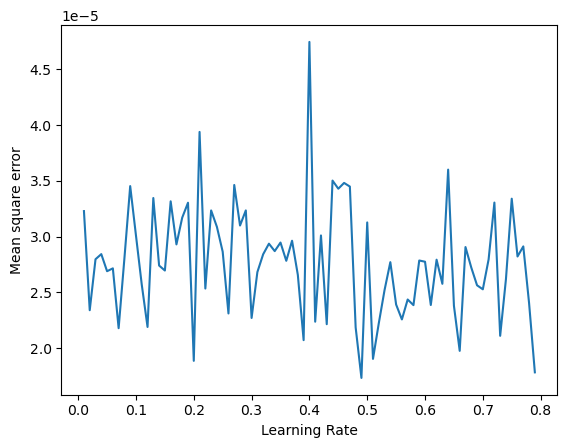

In [17]:
#finding the optimal hyperparamter that is learning rate for OLS
learning_rate = [i/100 for i in range(1, 80)]
merror = []
for i in learning_rate:
  error=0
  for training_index, testing_index in kf.split(x_train):
    X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
    Y_train, Y_test = y_train[training_index] , y_train[testing_index]
    w, b = fitlinearRegression(X_train, Y_train, 3000, i)
    error=error+returnMeanSqaure(w, b, X_test, Y_test)
  merror.append(error/no_of_splits)


plt.plot(learning_rate, merror)
plt.xlabel("Learning Rate")
plt.ylabel("Mean square error")
plt.show()


In [18]:
#getting the mse on test dataset on the optimal hyperparameter
w, b = fitlinearRegression(x_train, y_train, 3000, 0.185)
singleRunAnalysis(x_test, y_test, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameter
for _ in range(100):
    w, b = fitlinearRegression(x_train, y_train, 3000, 0.185)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[ 0.53083364]
 [ 0.09370388]
 [ 0.35619953]
 [ 0.4229701 ]
 [ 0.74024869]
 [ 0.96512801]
 [-0.00236066]
 [ 0.99221573]
 [ 0.38846928]
 [ 0.52304507]
 [ 0.77316474]
 [ 0.67262976]
 [ 0.19104595]]
Mean square error of  Regression
1.4747972998675074e-05
Standard Error of the coffecients
0.29912489183047214
0.26859991303311875
0.27903802376331005
0.27185642188484843
0.29491430836516136
0.29963927025868425
0.2937645266014
0.25534141511818753
0.27938971901503457
0.2989300942649581
0.26907931985400196
0.2912349211919703
0.27608093141480483


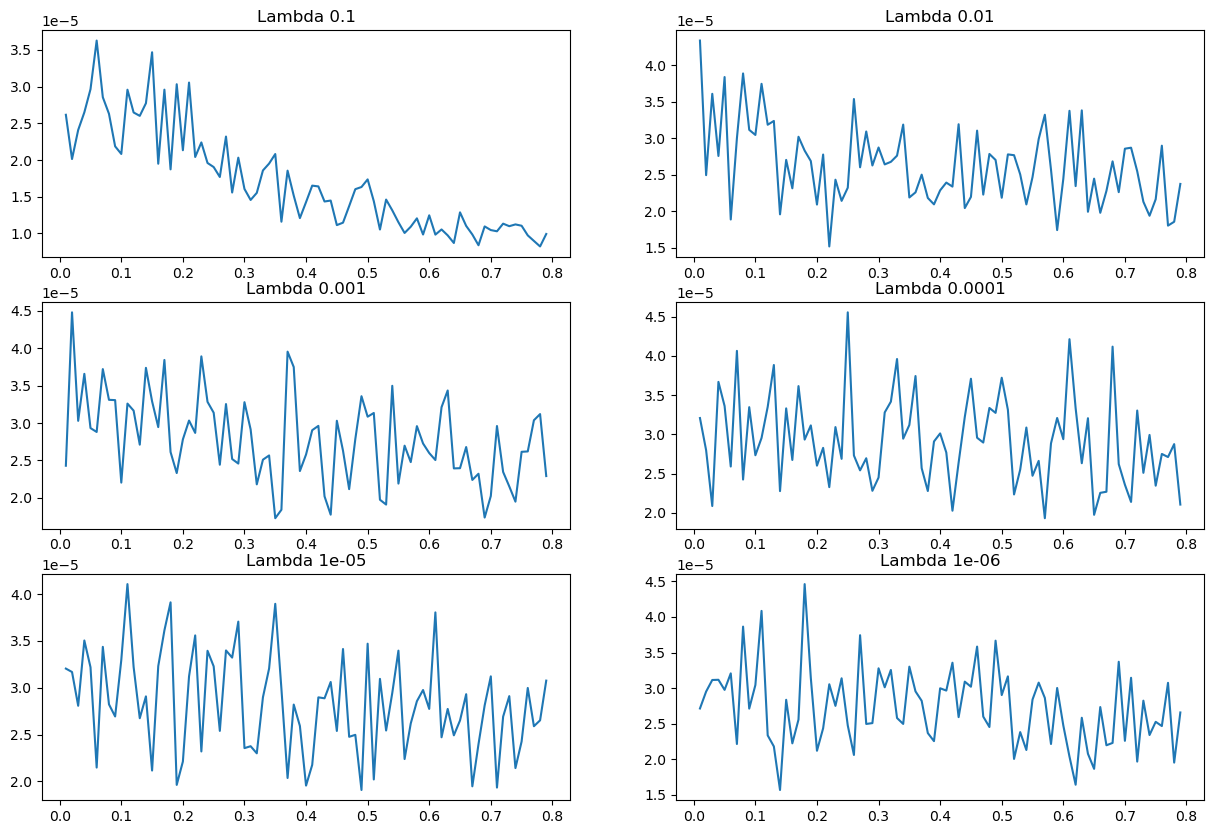

In [19]:
#finding the optimal hyperparamter that is learning rate and regularization constant for ridge regression
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = fitRidgeRegression(X_train, Y_train, 3000, j, i)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)



    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()

In [20]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitRidgeRegression(x_train, y_train, 3000, 0.1, 0.7)
singleRunAnalysis(x_test, y_test, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitRidgeRegression(x_train, y_train, 3000, 0.1, 0.)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[ 0.29016594]
 [ 0.02869846]
 [ 0.13561937]
 [ 0.02937726]
 [ 0.08064208]
 [ 0.25798881]
 [ 0.42181662]
 [ 0.37427775]
 [-0.01390071]
 [ 0.5507855 ]
 [ 0.42169781]
 [ 0.53236221]
 [ 0.15905271]]
Mean square error of  Regression
9.253812024122554e-06
Standard Error of the coffecients
0.29000416050474354
0.2931713952832498
0.274922658786282
0.26653252173843106
0.284761741005302
0.2930209573741365
0.31812905757577953
0.2794781755278253
0.29140814707208473
0.28497080450715107
0.27828897511323386
0.28987300223850765
0.27798600398785395


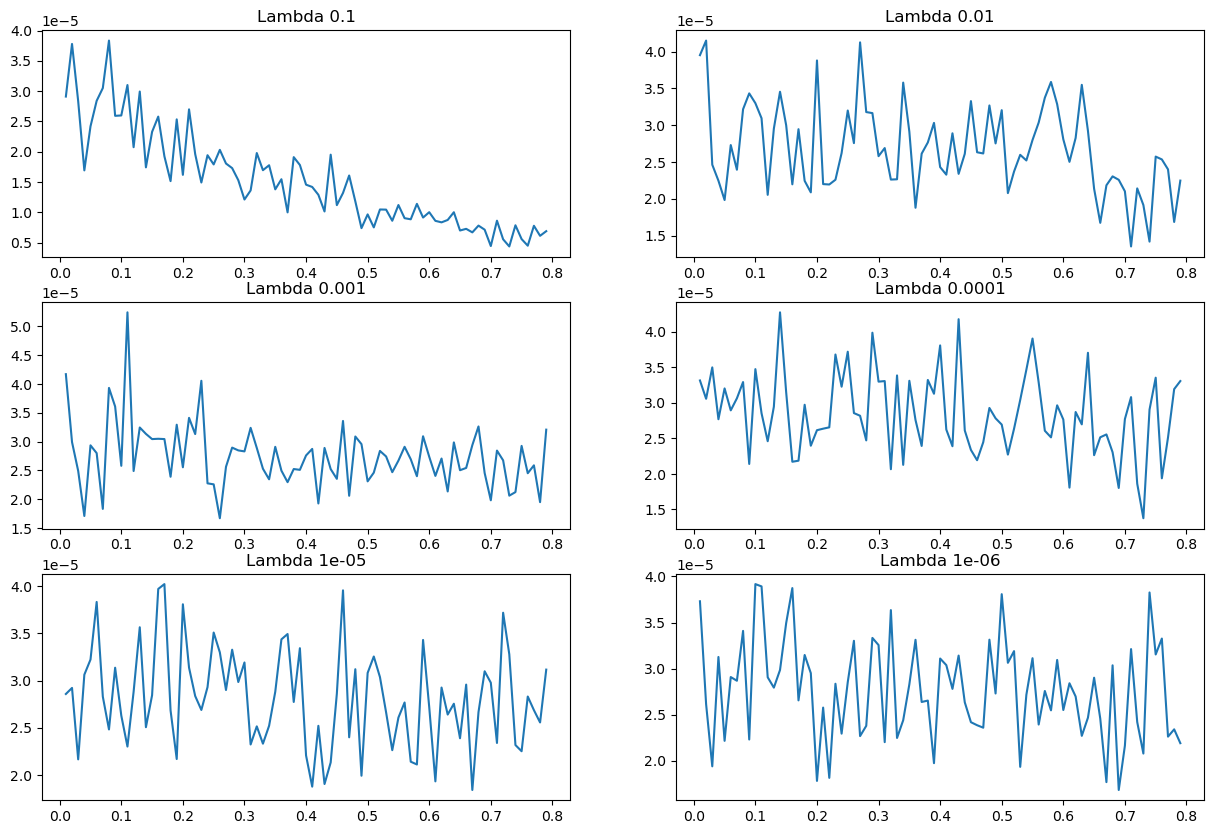

In [14]:
#finding the optimal hyperparamter that is learning rate and regularization constant for lasso regression
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
learning_rate = [i/100 for i in range(1, 80)]
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = fitLassoRegression(x, y, 3000, j, i)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()


In [ ]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitLassoRegression(x_train, y_train, 3000, 0.1, 0.757)
singleRunAnalysis(x_test, y_test, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitLassoRegression(x_train, y_train, 3000, 0.1, 0.77)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[ 1.84800700e-04]
 [ 8.19821536e-02]
 [ 1.18258458e-04]
 [ 2.52176375e-01]
 [ 8.83960696e-03]
 [ 2.65612422e-01]
 [ 1.35409539e-04]
 [-1.32308314e-04]
 [ 4.53666096e-02]
 [ 1.80185033e-04]
 [ 1.32535689e-04]
 [ 1.36111985e-01]
 [-3.80664968e-05]]
Mean square error of  Regression
1.0804267176161886e-06
Standard Error of the coffecients
0.12792780139106544
0.13833770777459153
0.12220147085933676
0.1349609014985424
0.11980151351854101
0.1393036697983015
0.1074757474116443
0.13910011824735796
0.11646168600685751
0.12167368204619257
0.12318174717178358
0.14988254892033662
0.1060144669245382


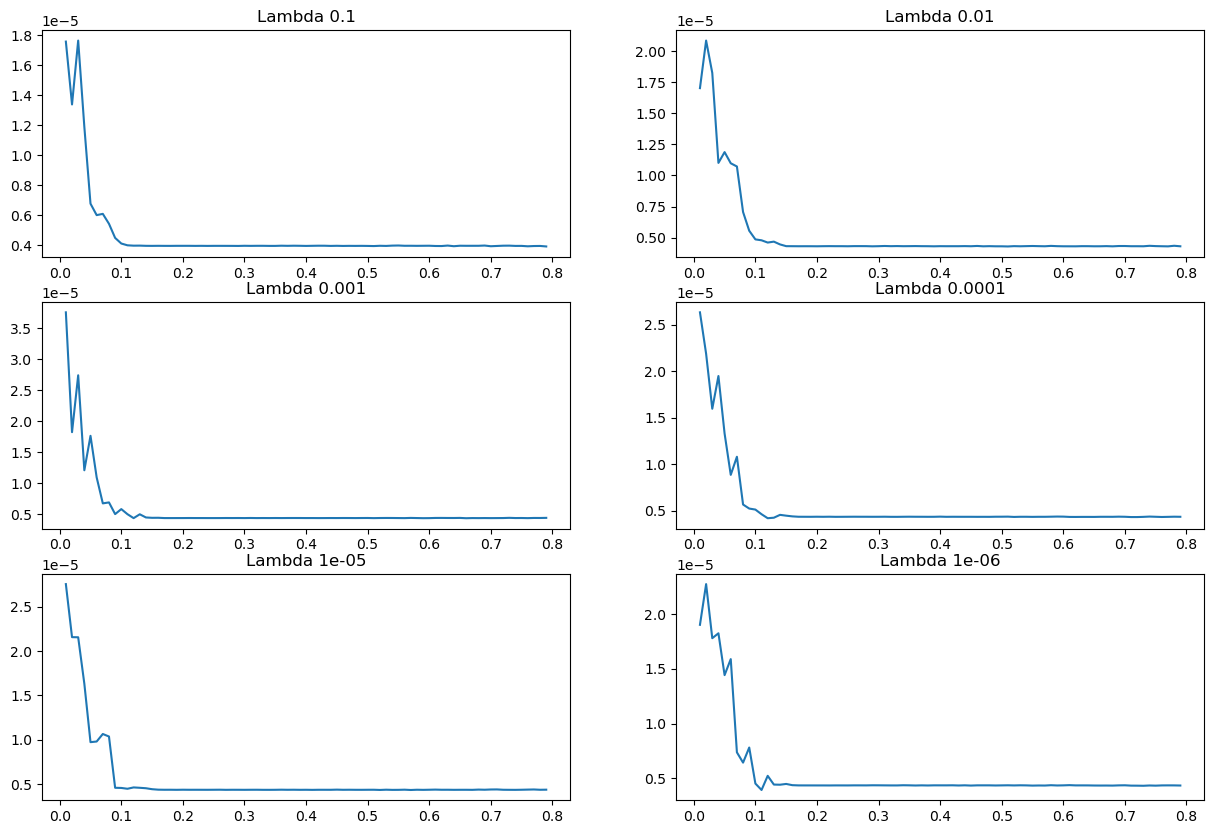

In [16]:
#finding the optimal hyperparamter that is learning rate and regularization constant for graph lasso regression

#building the priormatrix accodring to the Graph lasso research paper 
prioirmatrix = np.corrcoef(x_train, x_train)
for i in range(0,x_train.shape[0]):
  for j in range(0,x_train.shape[1]):
    if abs(prioirmatrix[i][j])>0.5:
      prioirmatrix[i][j]=1
    else:
      prioirmatrix[i][j]=0



fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = graphLassoRegression(x, y, 3000, j, i, prioirmatrix)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()

In [ ]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = graphLassoRegression(x, y, 3000, 0.1, 0.5, prioirmatrix)
singleRunAnalysis(x, y, w, b)


coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])


#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = graphLassoRegression(x, y, 3000, 0.1, 0.5, prioirmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[ 3.44149121e-04]
 [ 1.86069712e-04]
 [ 6.80074211e-04]
 [ 7.72784116e-04]
 [ 3.88758622e-04]
 [ 1.58295701e-04]
 [-3.65996548e-05]
 [-5.63019490e-04]
 [ 7.82462598e-04]
 [-5.44821770e-04]
 [-7.36336245e-04]
 [-4.99392261e-04]
 [ 8.80992050e-04]]
Mean square error of  Regression
3.687406873156142e-06
Standard Error of the coffecients
0.0004446588461197877
0.0004964854036324086
0.0005332101366802916
0.0004962427360937756
0.0005417935673947222
0.0005025766073871993
0.0005044565891203439
0.0005230280163083654
0.0005238036756148985
0.0004937849121195671
0.0005369375741822209
0.0005490148427569657
0.000497995602893122


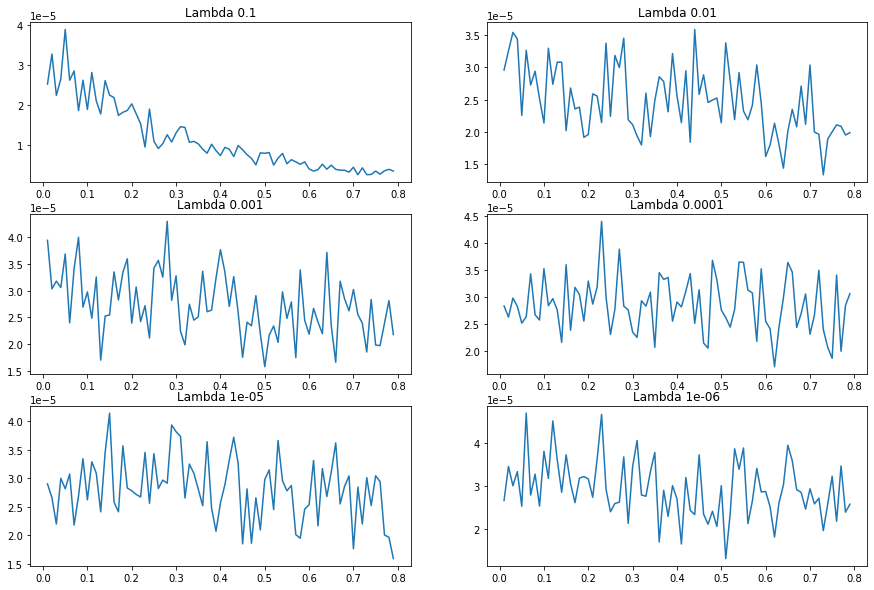

In [ ]:
#finding the optimal hyperparamter that is learning rate and regularization constant for Elastic lasso regression
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = fitElasticLassoRegression(x, y, 3000, j, i)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()


In [ ]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitElasticLassoRegression(x, y, 3000, 0.1, 0.7,)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitElasticLassoRegression(x, y, 3000, 0.1, 0.7)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[ 5.33208239e-05]
 [-8.28947191e-06]
 [ 1.07384103e-01]
 [ 4.89862625e-02]
 [ 6.44785167e-02]
 [ 2.78279766e-01]
 [ 3.53836809e-02]
 [ 2.56723671e-01]
 [ 1.13171960e-01]
 [-1.97181668e-05]
 [-2.98557207e-05]
 [ 1.12958811e-04]
 [ 2.59986703e-01]]
Mean square error of  Regression
3.1976908075335284e-06
Standard Error of the coffecients
0.09930389089553765
0.10361994529735338
0.08913515494150324
0.10587026453452385
0.10134231774534243
0.10421916373930558
0.09088941774471722
0.10333894568398153
0.08566239978284929
0.09708048269379244
0.09429192991465288
0.1106599657283667
0.09324694823830708


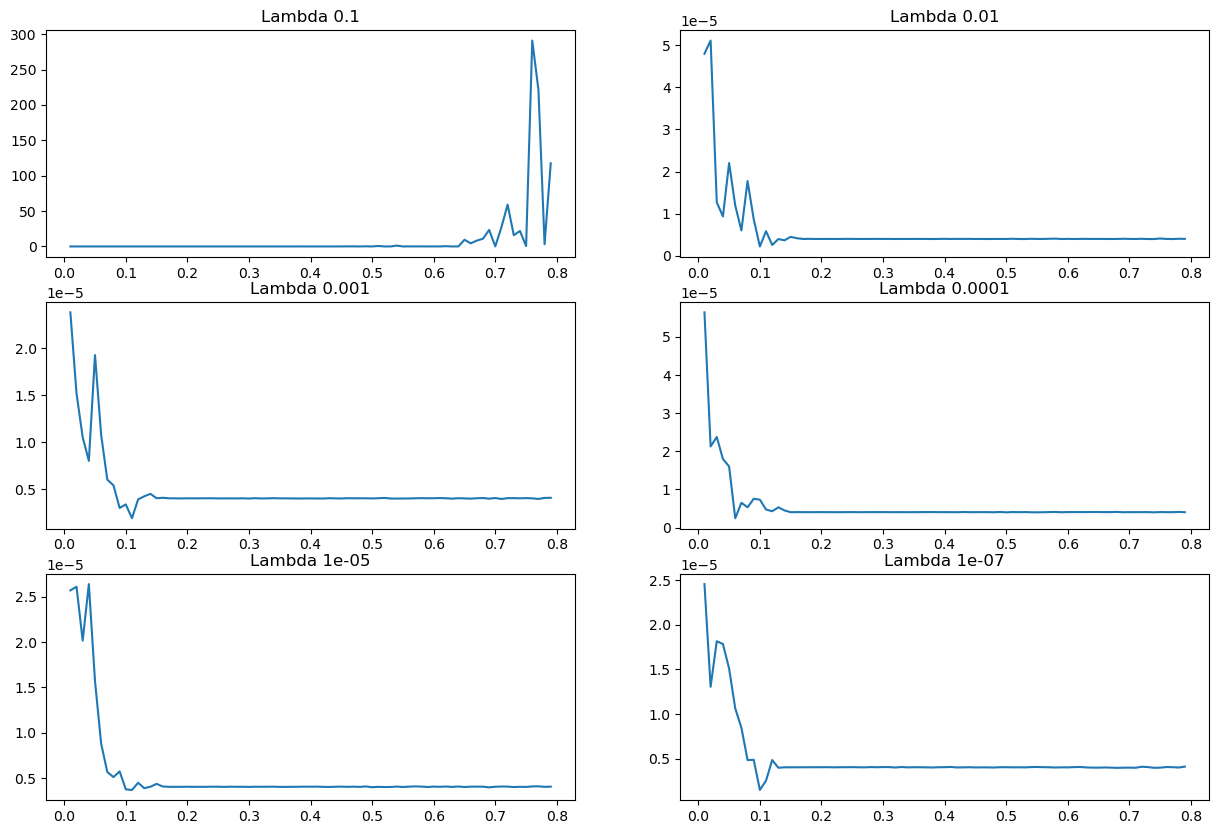

In [22]:
#finding the optimal hyperparamter that is learning rate and regularization constant for CGFLASSO(NEW APPROACH) regression

#building the priormatrix accodring to the knowledge of the domain
pmatrix=[[1,0.1,-0.7,0,0.3,-0.5,-0.5,0.6,0.4,-0.3,-0.7,0.8,0.9],
         [0.1,1,0.6,0.6,-0.5,0.7,0.6,0.5,0.8,0.9,0.7,-0.2,-0.4],
         [-0.7,0.6,1,0,-0.1,0.6,0.5,0.6,0.9,0.9,0.3,-0.1,0.6],
         [0,0,0,1,0,0,0,0,0,0,0,0,0],
         [0.7,-0.3,-0.1,0,1,-0.3,-0.8,-0.3,-0.1,-0.6,0.4,0.3,0.4],
         [-0.7,0.8,0.6,0,-0.6,1,0.7,-0.5,0.5,0.9,-0.7,-0.7,-0.8],
         [-0.8,0.6,0.7,0.6,0,0.7,1,0.7,0.8,0.7,-0.5,-0.7,-0.8],
         [0.7,0.5,0.8,0,-0.3,-0.5,0.5,1,0.5,0.5,0.7,0.7,0.9],
         [0.4,0.8,0.9,0,-0.1,0.5,0.8,0.5,1,0.3,0.8,-0.4,-0.3],
         [-0.3,0.9,0.9,0,-0.6,0.9,0.7,0.5,0.3,1,0.2,-0.4,-0.5],
         [-0.7,0.7,0.3,0,0.4,-0.7,-0.5,0.7,0.8,0.2,1,-0.7,-0.8],
         [0.8,-0.2,-0.1,0,0.3,-0.7,-0.7,0.7,-0.4,-0.4,-0.7,1,0.9],
         [0.9,-0.4,0.6,0,0.4,-0.8,-0.8,0.9,-0.3,-0.5,-0.8,0.9,1]]


fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        w, b = fitNewApproach(x, y, 3000, j, i, pmatrix)
        merror.append(returnMeanSqaure(w, b, x, y))

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0

plt.show()


In [23]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitNewApproach(x, y, 3000, 0.001, 0.2, pmatrix)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitNewApproach(x, y, 3000, 0.001, 0.2, pmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[-1.73160871e-04]
 [ 3.88902986e-04]
 [-2.76832264e-04]
 [ 1.39401002e-04]
 [ 2.46131849e-04]
 [-3.22669142e-04]
 [-3.29665644e-04]
 [ 5.27582832e-05]
 [-2.61437776e-04]
 [ 3.83764209e-04]
 [-2.31302924e-04]
 [ 3.88018524e-04]
 [-2.36673200e-04]]
Mean square error of  Regression
4.04509528752311e-06
Standard Error of the coffecients
0.00022865087480495246
0.0002100920019749421
0.00024052659951057985
0.00022917155780291892
0.00021075056611205968
0.00022349989555509888
0.00022859478774546414
0.00022352046613130977
0.00022974765482838556
0.00021719777710319107
0.000243637231272083
0.00022345228933081214
0.00020852461014271226


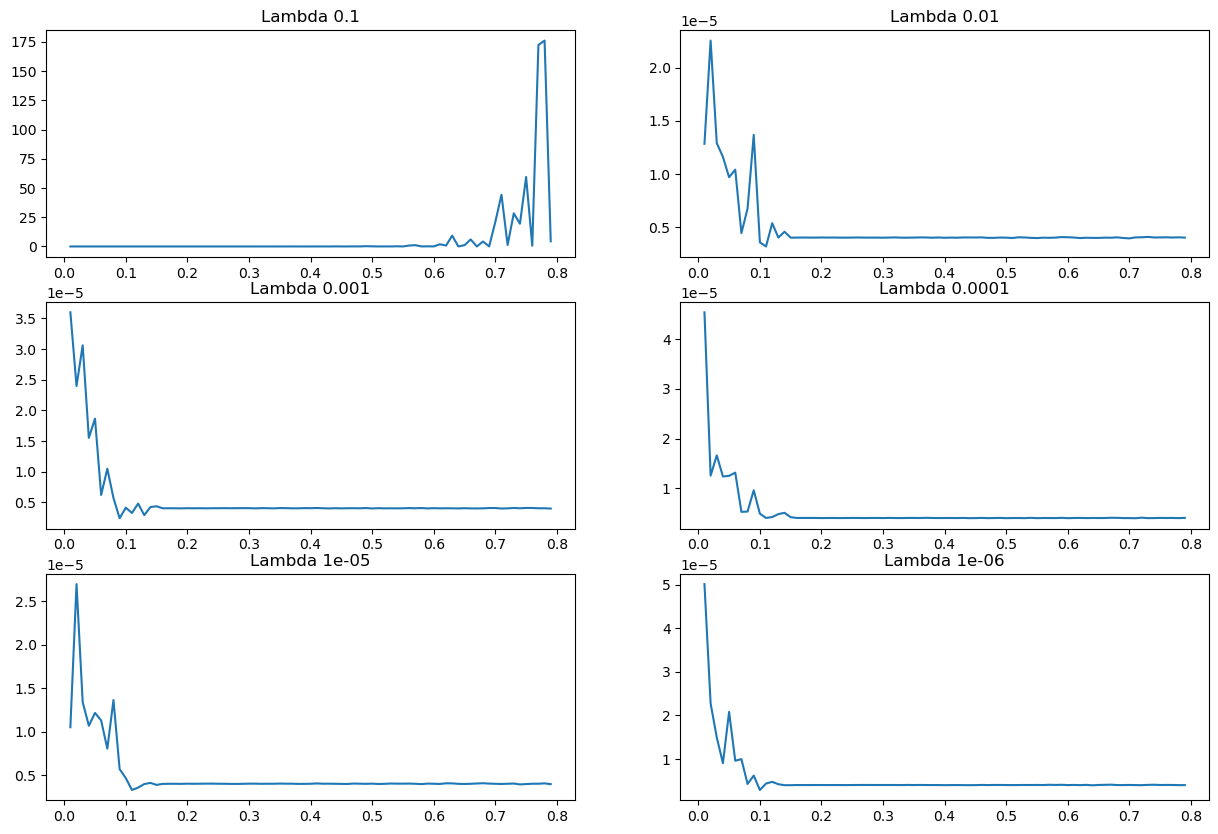

In [41]:
#finding the optimal hyperparamter that is learning rate and regularization constant for CGFLASSO(NEW APPROACH) regression

#building the priormatrix similar to the corrleation matrix value
pmatrix=df.drop(['MEDV'], axis=1).corr().round(1).to_numpy()

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        w, b = fitNewApproach(x, y, 3000, j, i, pmatrix)
        merror.append(returnMeanSqaure(w, b, x, y))

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0

plt.show()


In [42]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitNewApproach(x, y, 3000, 0.01, 0.5, pmatrix)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitNewApproach(x, y, 3000, 0.01, 0.5, pmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[-5.43413725e-05]
 [ 2.69153673e-04]
 [ 3.11846205e-05]
 [-6.35757710e-04]
 [ 5.01197375e-04]
 [ 2.63878675e-04]
 [ 4.29581542e-04]
 [ 4.44954991e-04]
 [ 3.69814317e-04]
 [-8.41475906e-04]
 [ 5.98123700e-04]
 [ 4.02223395e-04]
 [-4.11396051e-04]]
Mean square error of  Regression
3.9656678103886584e-06
Standard Error of the coffecients
0.0005076936862222063
0.0005305597057996419
0.0005376568507929709
0.0005705848855458371
0.0005574521968170073
0.0005425172989417863
0.0005380117089642452
0.0005566133697276618
0.0005781430211580033
0.0005896057075154611
0.00051280702457813
0.0006234605397599432
0.0005164190229014686


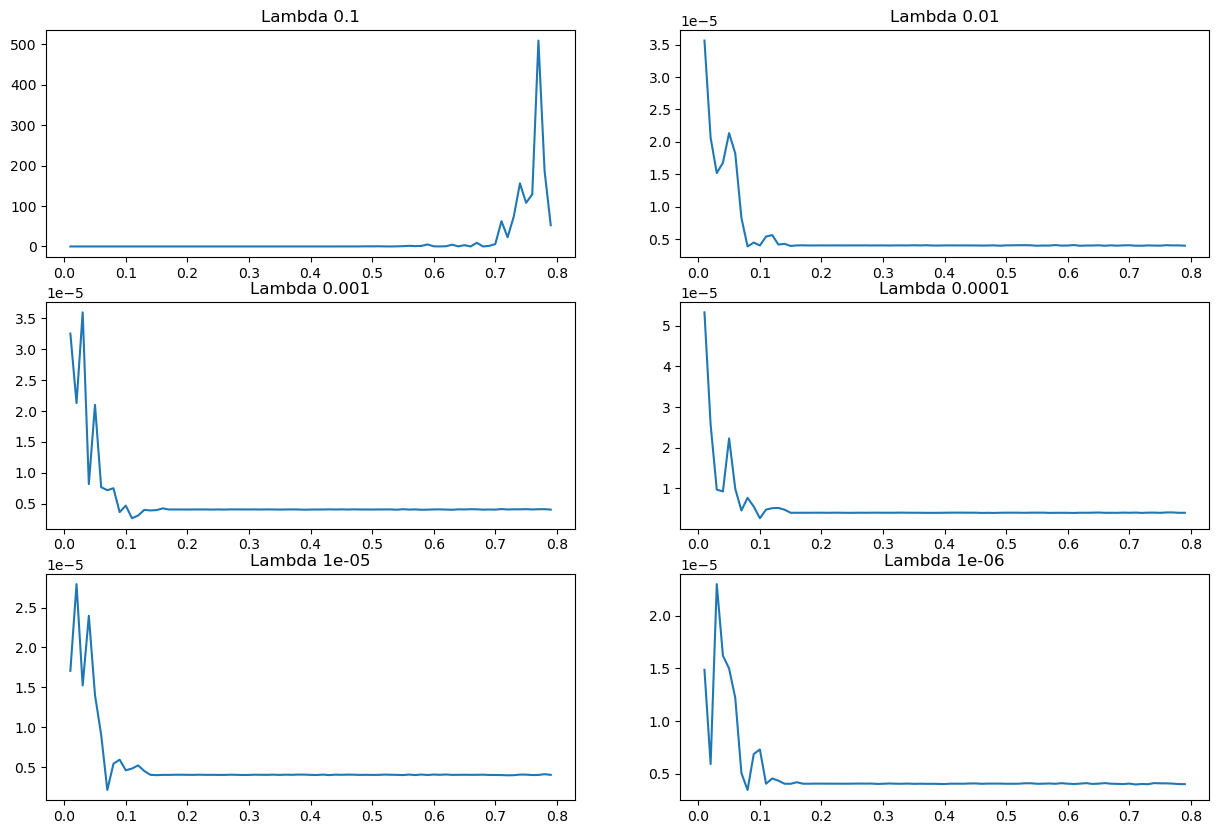

In [51]:
#finding the optimal hyperparamter that is learning rate and regularization constant for CGFLASSO(NEW APPROACH) regression

#building the priormatrix same like Graph Lasso
pmatrix=df.drop(['MEDV'], axis=1).corr().to_numpy()
for i in range(0,x_train.shape[1]):
  for j in range(0,x_train.shape[1]):
    if abs(pmatrix[i][j])>0.5:
      pmatrix[i][j]=1
    else:
      pmatrix[i][j]=0

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        w, b = fitNewApproach(x, y, 3000, j, i, pmatrix)
        merror.append(returnMeanSqaure(w, b, x, y))

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0

plt.show()


In [52]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitNewApproach(x, y, 3000, 0.000001, 0.5, pmatrix)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])


#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitNewApproach(x, y, 3000, 0.000001, 0.5, pmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[ 5.01636736e-04]
 [ 5.54570319e-05]
 [-2.45619062e-04]
 [ 6.88528750e-04]
 [ 2.18731696e-04]
 [-2.62002690e-04]
 [-6.11902093e-04]
 [ 6.79799417e-04]
 [-8.85198702e-04]
 [ 8.75504671e-04]
 [ 8.19563715e-04]
 [ 5.75369363e-04]
 [ 1.57774446e-04]]
Mean square error of  Regression
4.033350895976782e-06
Standard Error of the coffecients
0.000569252096973909
0.0005734953616760462
0.0005750833341567642
0.000544758847951963
0.0005407951467629338
0.0005304978355067382
0.0005461385034096408
0.0005510669574457089
0.0005570735015700317
0.0005923872990609138
0.0005621435531767907
0.0005341335815469505
0.0005929908405601532


In [13]:
#finding the standdeviation of the standerror of the coffecients on different priormatrix 
learning_rate = [i/100 for i in range(1, 80)]
stanalysis=[[] for j in range(0,x.shape[1])]
for a in range(0,30):
        coff=np.random.rand()
        epsilon=np.random.uniform(low=0, high=0.05)
        if coff < 0.5:
             epsilon=-1*epsilon
        pmatrix=df.drop(['MEDV'], axis=1).corr().to_numpy()
        for i in range(0,x_train.shape[1]):
            for j in range(0,x_train.shape[1]):
                 pmatrix[i][j]=pmatrix[i][j]+epsilon
                 if pmatrix[i][j] > 1:
                      pmatrix[i][j]=1
                 elif pmatrix[i][j] < 0:
                      pmatrix[i][j]=0
    
        lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
        pmses=[]
        for j in lambda_value:
            pmses.append([])
            t=len(pmses)-1
            for i in learning_rate:
                w, b = fitNewApproach(x, y, 3000, j, i, pmatrix)
                temp=returnMeanSqaure(w, b, x, y)
                pmses[t].append(temp)
        

        rlambda=0
        rlearning=0
        tmin=1e9
        for i in range(0,len(lambda_value)):
             temp=min(pmses[i])
             index=np.where(pmses == temp)[0][0]
             if temp < tmin:
                  tmin=temp
                  rlambda=lambda_value[i]
                  rlearning=index/100
        coffecientlist = []     
        for _ in range(x.shape[1]):
            coffecientlist.append([])
        for _ in range(100):
             w, b = fitNewApproach(x, y, 3000, rlambda, rlearning, pmatrix)
             for i in range(x.shape[1]):
                  coffecientlist[i].append(w[i][0])
        for i in range(x.shape[1]):
             stanalysis[i].append(np.array(coffecientlist[i]).std())



for i in range(x.shape[1]):
        print(np.array(stanalysis[i]).std())

        



0.02221076905840534
0.021207762392550896
0.024363535207362123
0.020264747228186476
0.020534765997575796
0.02215857037539962
0.024904601814011617
0.021381029649410365
0.0253368544181956
0.020743804481198728
0.023692314591602884
0.023617869216793482
0.026417987173495805
